In [1]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [2]:
match_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/664389efa0868_match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b548c98c_batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b2c60743_bowler_level_scorecard.csv')
train_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b6d54457_train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/6644a1e287df6_test_data_with_samplefeatures.csv')

In [3]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [4]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.

    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}

    Output-None

    Returns- dataframe having bowling/batting stats from last n games of a player before an input date.
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [5]:
#new feature 1 bowler's performance of teams in recent mathes
def team_bowler_performance_recent(bowler_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_impact_score = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        if not recent_matches.empty:
            player_impact = (recent_matches['wicket_count']) * 5 + recent_matches['dots']*1.5+(recent_matches['maiden']) * 1.5 -(recent_matches['Fours'] * 1) - recent_matches['Sixes']*1.5 - recent_matches['wides'] - recent_matches['noballs']                          
                           
                            
                             
            total_impact_score += player_impact.sum()

    return total_impact_score

train_data['team1_bowler_performance_recent'] = train_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_bowler_performance_recent'] = train_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)



In [6]:
# def calculate_ratio(row):
#     team1_value = row['team1_bowler_performance_recent']
#     team2_value = row['team2_bowler_performance_recent']
#     if team2_value == 0:
#         return team1_value
#     else:
#         return team1_value / team2_value

# # Add the new column to the DataFrame
# train_data['team_bowler_performance_ratio'] = train_data.apply(calculate_ratio, axis=1)

# # Drop the initial individual features
# train_data = train_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])


In [7]:
def calculate_ratio(row, col1, col2):
    value1 = row[col1]
    value2 = row[col2]
    if value2 == 0:
        return value1
    else:
        return value1 / value2

# Function to add a ratio column for any two columns
def add_ratio_column(df, col1, col2, new_col_name):
    df[new_col_name] = df.apply(lambda row: calculate_ratio(row, col1, col2), axis=1)
    return df

# Add the new column to the DataFrame
train_data = add_ratio_column(train_data, 'team1_bowler_performance_recent', 'team2_bowler_performance_recent', 'team_bowler_performance_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])


In [8]:
test_data['team1_bowler_performance_recent'] = test_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_bowler_performance_recent'] = test_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)
test_data = add_ratio_column(test_data, 'team1_bowler_performance_recent', 'team2_bowler_performance_recent', 'team_bowler_performance_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])


In [9]:
def team_batsman_performance_recent(bat_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] * 4.5 +
                                  recent_matches['strike_rate'] * 2.5 +
                                  (recent_matches['Fours'] + recent_matches['Sixes'] ) * 1.5) 
                                  
            total_performance_index += player_performance.sum()

    return total_performance_index

train_data['team1_batsman_performance_recent'] = train_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_batsman_performance_recent'] = train_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team1_batsman_performance_recent'] = test_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_batsman_performance_recent'] = test_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

# Add the new column to the DataFrame
train_data = add_ratio_column(train_data, 'team1_batsman_performance_recent', 'team2_batsman_performance_recent', 'team_batsmen_performance_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_batsman_performance_recent', 'team2_batsman_performance_recent'])


test_data = add_ratio_column(test_data, 'team1_batsman_performance_recent', 'team2_batsman_performance_recent', 'team_batsmen_performance_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_batsman_performance_recent', 'team2_batsman_performance_recent'])





In [10]:
def team_batsman_runs_recent(bat_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] ) 
                                  
            total_performance_index += player_performance.sum()

    return total_performance_index

train_data['team1_batsman_runs_recent'] = train_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_batsman_runs_recent'] = train_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team1_batsman_runs_recent'] = test_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_batsman_runs_recent'] = test_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

# Add the new column to the DataFrame
train_data = add_ratio_column(train_data, 'team1_batsman_runs_recent', 'team2_batsman_runs_recent', 'team_batsman_runs_recent_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_batsman_runs_recent', 'team2_batsman_runs_recent'])


test_data = add_ratio_column(test_data, 'team1_batsman_runs_recent', 'team2_batsman_runs_recent', 'team_batsman_runs_recent_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_batsman_runs_recent', 'team2_batsman_runs_recent'])





In [11]:
match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)



In [12]:
def teamAvgRunsLastn(team_id, date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
                         df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
    return df_rel['runs'].mean() # return mean of the combined dataframe.

train_data['team2only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)


train_data['team1only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)


train_data['team1run-ground_avg_runs'] = train_data['team1only_avg_runs_last15'] - train_data['ground_avg_runs_last15']
train_data['team2run-ground_avg_runs'] = train_data['team2only_avg_runs_last15'] - train_data['ground_avg_runs_last15']

train_data = add_ratio_column(train_data, 'team1run-ground_avg_runs', 'team2run-ground_avg_runs', 'team_ground_factor_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1run-ground_avg_runs', 'team2run-ground_avg_runs','team2only_avg_runs_last15','team1only_avg_runs_last15'])



test_data['team2only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)


test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)


test_data['team1run-ground_avg_runs'] = test_data['team1only_avg_runs_last15'] - test_data['ground_avg_runs_last15']
test_data['team2run-ground_avg_runs'] = test_data['team2only_avg_runs_last15'] - test_data['ground_avg_runs_last15']

test_data = add_ratio_column(test_data, 'team1run-ground_avg_runs', 'team2run-ground_avg_runs', 'team_ground_factor_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1run-ground_avg_runs', 'team2run-ground_avg_runs','team2only_avg_runs_last15','team1only_avg_runs_last15'])


100%|██████████| 271/271 [00:00<00:00, 1057.96it/s]


In [13]:
def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.
    
    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.
    
    Output- None
    
    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      (((match_lvl_data['team1_id']==team1_id)&(match_lvl_data['team2_id']==team2_id))|((match_lvl_data['team1_id']==team2_id)&(match_lvl_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.


# In[34]:


# Compute team1 win% against team2 in their past 15 encounters for train data.
train_data['team1_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 15), axis=1)
train_data['team2_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team2_id'], x['team1_id'], x['match_dt'], 15), axis=1)

test_data['team1_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 15), axis=1)
test_data['team2_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team2_id'], x['team1_id'], x['match_dt'], 15), axis=1)



100%|██████████| 271/271 [00:00<00:00, 2090.81it/s]


In [14]:
def winpLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

train_data['team1_winp_last10'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 10), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_winp_last10'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 10), axis=1)

train_data['diff_win_p_teams'] = train_data['team1_winp_last10'] - train_data['team2_winp_last10']
train_data = train_data.drop(columns=['team1_winp_last10', 'team2_winp_last10'])


test_data['team1_winp_last10'] = test_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 10), axis=1)
# Compute team2's win% in last 5 games
test_data['team2_winp_last10'] = test_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 10), axis=1)

test_data['diff_win_p_teams'] = test_data['team1_winp_last10'] - test_data['team2_winp_last10']
test_data = test_data.drop(columns=['team1_winp_last10', 'team2_winp_last10'])



100%|██████████| 271/271 [00:00<00:00, 2444.83it/s]


In [15]:
def team_economy_rate_recent(bowler_df, team_roster_ids, date, n=10):
    team_ids = str(team_roster_ids).split(':')
    total_runs_given = 0
    total_balls_bowled = 0
    
    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        total_runs_given += recent_matches['runs'].sum()
        total_balls_bowled += recent_matches['balls_bowled'].sum()

    if total_balls_bowled > 0:
        return (total_runs_given / total_balls_bowled) * 6
    return 0

# Apply this function
train_data['team1_economy_rate_recent'] = train_data.apply(
    lambda x: team_economy_rate_recent(bowler_lvl_data, x['team1_roster_ids'], x['match_dt']),
    axis=1
)
train_data['team2_economy_rate_recent'] = train_data.apply(
    lambda x: team_economy_rate_recent(bowler_lvl_data, x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team1_economy_rate_recent'] = test_data.apply(
    lambda x: team_economy_rate_recent(bowler_lvl_data, x['team1_roster_ids'], x['match_dt']),
    axis=1
)
test_data['team2_economy_rate_recent'] = test_data.apply(
    lambda x: team_economy_rate_recent(bowler_lvl_data, x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_economy_rate_recent', 'team2_economy_rate_recent', 'team_economy_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_economy_rate_recent', 'team2_economy_rate_recent'])


test_data = add_ratio_column(test_data, 'team1_economy_rate_recent', 'team2_economy_rate_recent', 'team_economy_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_economy_rate_recent', 'team2_economy_rate_recent'])


In [16]:
def player_of_match_frequency(matches, team_roster_ids, date):
    team_ids = str(team_roster_ids).split(':')
    pom_awards = 0
    total_matches = 0

    for player_id in team_ids:
        past_matches = matches[(matches['match_dt'] < date) & (matches['player_of_the_match_id'] == float(player_id))]
        pom_awards += past_matches.shape[0]
        total_matches += matches[(matches['match_dt'] < date) & ((matches['team1_roster_ids'].str.contains(str(player_id))) | (matches['team2_roster_ids'].str.contains(str(player_id))))].shape[0]

    return pom_awards / total_matches if total_matches > 0 else 0

train_data['team1_pom_frequency'] = train_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_pom_frequency'] = train_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data['team1_pom_frequency'] = test_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_pom_frequency'] = test_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)


train_data = add_ratio_column(train_data, 'team1_pom_frequency', 'team2_pom_frequency', 'team_playerOfmatch_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_pom_frequency', 'team2_pom_frequency'])


test_data = add_ratio_column(test_data, 'team1_pom_frequency', 'team2_pom_frequency', 'team_playerOfmatch_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_pom_frequency', 'team2_pom_frequency'])





In [17]:
def team_count_100runs_last15(matches, team1_roster, team2_roster, date, n=25):
    def count_100s(team_roster):
        total_100s = 0
        for player_id in team_roster.split(':'):
            player_matches = giveLastNgamesPlayer(player_id, date, n, 'bat')
            total_100s += (player_matches['runs'] >= 75).sum()
        return total_100s

    team1_100s = count_100s(team1_roster)
    team2_100s = count_100s(team2_roster)

    return team1_100s / team2_100s if team2_100s > 0 else team1_100s

train_data['team_count_100runs_ratio_last15'] = train_data.apply(lambda x: team_count_100runs_last15(match_lvl_data, x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt']), axis=1)
test_data['team_count_100runs_ratio_last15'] = test_data.apply(lambda x: team_count_100runs_last15(match_lvl_data, x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt']), axis=1)


In [18]:
def avg_extras_conceded(matches, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    total_extras = 0
    total_matches = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bowl')
        total_extras += recent_matches['wides'].sum() + recent_matches['noballs'].sum()
        total_matches += recent_matches.shape[0]

    return total_extras / total_matches if total_matches > 0 else 0

train_data['team1_avg_extras_conceded'] = train_data.apply(lambda x: avg_extras_conceded(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_avg_extras_conceded'] = train_data.apply(lambda x: avg_extras_conceded(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data['team1_avg_extras_conceded'] = test_data.apply(lambda x: avg_extras_conceded(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_avg_extras_conceded'] = test_data.apply(lambda x: avg_extras_conceded(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)


#add ratio column 
train_data = add_ratio_column(train_data, 'team1_avg_extras_conceded', 'team2_avg_extras_conceded', 'teams_avg_extras_conceded_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_avg_extras_conceded', 'team2_avg_extras_conceded'])

#add ratio column 
test_data = add_ratio_column(test_data, 'team1_avg_extras_conceded', 'team2_avg_extras_conceded', 'teams_avg_extras_conceded_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_avg_extras_conceded', 'team2_avg_extras_conceded'])


In [19]:
def avg_partnership_length(matches, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    total_partnership_runs = 0
    total_partnerships = 0

    for player_id in team_ids[:6]:  # Assuming top 4 are the main batsmen
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bat')
        total_partnership_runs += recent_matches['runs'].sum()
        total_partnerships += recent_matches.shape[0]

    return total_partnership_runs / total_partnerships if total_partnerships > 0 else 0

train_data['team1_avg_partnership_length'] = train_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_avg_partnership_length'] = train_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)
test_data['team1_avg_partnership_length'] = test_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_avg_partnership_length'] = test_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)



#add ratio column 
train_data = add_ratio_column(train_data, 'team1_avg_partnership_length', 'team2_avg_partnership_length', 'team_avg_partnership_length_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_avg_partnership_length', 'team2_avg_partnership_length'])


#add ratio column 
test_data = add_ratio_column(test_data, 'team1_avg_partnership_length', 'team2_avg_partnership_length', 'team_avg_partnership_length_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_avg_partnership_length', 'team2_avg_partnership_length'])


In [20]:
def avg_wickets_top5_bowlers(bowler_df, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    bowlers_wickets = []

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bowl')
        if not recent_matches.empty:
            total_wickets = recent_matches['wicket_count'].sum()
            bowlers_wickets.append(total_wickets)

    bowlers_wickets.sort(reverse=True)
    top5_bowlers_wickets = bowlers_wickets[:5]

    return sum(top5_bowlers_wickets) / 5 if len(top5_bowlers_wickets) == 5 else sum(top5_bowlers_wickets) / len(top5_bowlers_wickets) if len(top5_bowlers_wickets) > 0 else 0

train_data['team1_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'avg_wickets_top5_bowlers_ratio')
train_data = train_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

test_data['team1_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'avg_wickets_top5_bowlers_ratio')
test_data = test_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])


In [21]:
# very good
def win_percentage_fielding_first(matches, team_id, date):
    fielding_first_matches = matches[((matches['team1_id'] == team_id) & (matches['toss decision'] == 'field')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'field')) & (matches['match_dt'] < date)]
    wins = fielding_first_matches[fielding_first_matches['winner_id'] == team_id].shape[0]
    total_matches = fielding_first_matches.shape[0]
    return (wins / total_matches) * 100 if total_matches > 0 else 0

train_data['team1_win_percentage_fielding_first'] = train_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_win_percentage_fielding_first'] = train_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first', 'win_percentage_fielding_first_ratio')
train_data = train_data.drop(columns=['team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first'])

test_data['team1_win_percentage_fielding_first'] = test_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_win_percentage_fielding_first'] = test_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first', 'win_percentage_fielding_first_ratio')
test_data = test_data.drop(columns=['team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first'])


In [22]:
# good
def win_percentage_batting_first(matches, team_id, date):
    batting_first_matches = matches[((matches['team1_id'] == team_id) & (matches['toss decision'] == 'bat')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'bat')) & (matches['match_dt'] < date)]
    wins = batting_first_matches[batting_first_matches['winner_id'] == team_id].shape[0]
    total_matches = batting_first_matches.shape[0]
    return (wins / total_matches) * 100 if total_matches > 0 else 0

train_data['team1_win_percentage_batting_first'] = train_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_win_percentage_batting_first'] = train_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_percentage_batting_first', 'team2_win_percentage_batting_first', 'win_percentage_batting_first_ratio')
train_data = train_data.drop(columns=['team1_win_percentage_batting_first', 'team2_win_percentage_batting_first'])

test_data['team1_win_percentage_batting_first'] = test_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_win_percentage_batting_first'] = test_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_percentage_batting_first', 'team2_win_percentage_batting_first', 'win_percentage_batting_first_ratio')
test_data = test_data.drop(columns=['team1_win_percentage_batting_first', 'team2_win_percentage_batting_first'])


In [23]:
# good
def avg_runs_per_wicket_last5(batsman_df, team_roster_ids, date, n=5):
    team_ids = team_roster_ids.split(':')
    total_runs = 0
    total_wickets = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bat')
        total_runs += recent_matches['runs'].sum()
        total_wickets += recent_matches[recent_matches['wicket kind'] != 'not out'].shape[0]

    return total_runs / total_wickets if total_wickets > 0 else 0

train_data['team1_avg_runs_per_wicket_last5'] = train_data.apply(lambda x: avg_runs_per_wicket_last5(batsman_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_avg_runs_per_wicket_last5'] = train_data.apply(lambda x: avg_runs_per_wicket_last5(batsman_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_runs_per_wicket_last5', 'team2_avg_runs_per_wicket_last5', 'avg_runs_per_wicket_ratio_last5')
train_data = train_data.drop(columns=['team1_avg_runs_per_wicket_last5', 'team2_avg_runs_per_wicket_last5'])

test_data['team1_avg_runs_per_wicket_last5'] = test_data.apply(lambda x: avg_runs_per_wicket_last5(batsman_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_avg_runs_per_wicket_last5'] = test_data.apply(lambda x: avg_runs_per_wicket_last5(batsman_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_runs_per_wicket_last5', 'team2_avg_runs_per_wicket_last5', 'avg_runs_per_wicket_ratio_last5')
test_data = test_data.drop(columns=['team1_avg_runs_per_wicket_last5', 'team2_avg_runs_per_wicket_last5'])


In [24]:
# okay
def avg_win_margin_runs(matches, team_id, date):
    win_by_runs_matches = matches[(matches['by'] == 'runs') & ((matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)) & (matches['match_dt'] < date)]
    total_margin = win_by_runs_matches[win_by_runs_matches['winner_id'] == team_id]['win amount'].sum()
    total_matches = win_by_runs_matches[win_by_runs_matches['winner_id'] == team_id].shape[0]
    return total_margin / total_matches if total_matches > 0 else 0

train_data['team1_avg_win_margin_runs'] = train_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_avg_win_margin_runs'] = train_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_win_margin_runs', 'team2_avg_win_margin_runs', 'avg_win_margin_runs_ratio')
train_data = train_data.drop(columns=['team1_avg_win_margin_runs', 'team2_avg_win_margin_runs'])

test_data['team1_avg_win_margin_runs'] = test_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_avg_win_margin_runs'] = test_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_win_margin_runs', 'team2_avg_win_margin_runs', 'avg_win_margin_runs_ratio')
test_data = test_data.drop(columns=['team1_avg_win_margin_runs', 'team2_avg_win_margin_runs'])


In [25]:
new_train1  = train_data.copy()
new_train2 = train_data.copy()

In [26]:
test_data1 = test_data.copy()
test_data2 = test_data.copy()

In [27]:
new_test_data = test_data.copy()

In [28]:
new_train = train_data.copy()

In [29]:
new_train1['winner_01'] = new_train1.apply(lambda x: 1 if (x['team2']==x['winner']) else 0, axis=1)

In [30]:
new_train1['toss_winner_01'] = np.where(new_train1['toss winner']==new_train1['team2'], 1, 0)
new_test_data['toss_winner_01'] = np.where(new_test_data['toss winner']==new_test_data['team2'], 1, 0)
new_train1['toss_decision_01'] = np.where(new_train1['toss decision']=='bat', 1, 0)
new_test_data['toss_decision_01'] = np.where(new_test_data['toss decision']=='bat', 1, 0)

In [31]:
train_data['toss_winner_01'] = np.where(train_data['toss winner']==train_data['team2'], 1, 0)
test_data['toss_winner_01'] = np.where(test_data['toss winner']==test_data['team2'], 1, 0)
train_data['toss_decision_01'] = np.where(train_data['toss decision']=='bat', 1, 0)
test_data['toss_decision_01'] = np.where(test_data['toss decision']=='bat', 1, 0)

In [32]:
drops = ['match id', 'team1','venue', 'team1_id', 'team1_roster_ids', 'team2','winner','winner_id','toss winner',
       'team2_id','toss decision', 'team2_roster_ids','city','match_dt','lighting','series_name','season','ground_id']

new_train1 = new_train1.drop(drops,axis = 1)

drops_test = ['match id', 'team1','venue', 'team1_id', 'team1_roster_ids', 'team2','toss winner',
       'team2_id','toss decision', 'team2_roster_ids','city','match_dt','lighting','series_name','season','ground_id']

new_test_data = new_test_data.drop(drops_test,axis = 1)


In [33]:
# new_train1 = new_train1.drop('team_count_50runs_last15',axis = 1)
# new_test_data = new_test_data.drop('team_count_50runs_last15',axis = 1)

In [34]:
# cols = ['team_winp_last5', 'team1_winp_team2_last15', 'ground_avg_runs_last15',
#        'team_bowler_performance_ratio', 'team_batsmen_performance_ratio',
#        'team_ground_factor_ratio', 'team2_winp_team2_last15',
#        'diff_win_p_teams', 'team_economy_ratio', 'team_playerOfmatch_ratio',
#        'team_count_100runs_ratio_last15', 'teams_avg_extras_conceded_ratio',
#        'team_avg_partnership_length_ratio', 'toss_winner_01',
#        'toss_decision_01']

cols = ['team_winp_last5', 'win_percentage_fielding_first_ratio',
       'team_bowler_performance_ratio', 'team_batsmen_performance_ratio',
        'avg_wickets_top5_bowlers_ratio','avg_runs_per_wicket_ratio_last5',
       'diff_win_p_teams',  'win_percentage_batting_first_ratio','team_playerOfmatch_ratio',
       'team_count_50runs_last15', 'avg_win_margin_runs_ratio',
       'team_avg_partnership_length_ratio', 'toss_winner_01',
       'toss_decision_01']

X,y = new_train1[cols],new_train1['winner_01']

In [35]:
X_sub = new_test_data.copy()

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [37]:
X.fillna(0,inplace=True)
X_sub.fillna(0,inplace=True)
X.isna().sum()

/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_79016/3528972766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0,inplace=True)


team_winp_last5                        0
win_percentage_fielding_first_ratio    0
team_bowler_performance_ratio          0
team_batsmen_performance_ratio         0
avg_wickets_top5_bowlers_ratio         0
avg_runs_per_wicket_ratio_last5        0
diff_win_p_teams                       0
win_percentage_batting_first_ratio     0
team_playerOfmatch_ratio               0
team_count_50runs_last15               0
avg_win_margin_runs_ratio              0
team_avg_partnership_length_ratio      0
toss_winner_01                         0
toss_decision_01                       0
dtype: int64

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
GBM_model = GradientBoostingClassifier()
LGBM_model = LGBMClassifier()
XGB_model = XGBClassifier()
CatBoost_model = CatBoostClassifier()

# Train the models
GBM_model.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)
CatBoost_model.fit(X_train, y_train)

# Make predictions
y_pred_GBM = GBM_model.predict(X_test)
y_pred_LGBM = LGBM_model.predict(X_test)
y_pred_XGB = XGB_model.predict(X_test)
y_pred_CatBoost = CatBoost_model.predict(X_test)

# Evaluate models
accuracy_GBM = accuracy_score(y_test, y_pred_GBM)
accuracy_LGBM = accuracy_score(y_test, y_pred_LGBM)
accuracy_XGB = accuracy_score(y_test, y_pred_XGB)
accuracy_CatBoost = accuracy_score(y_test, y_pred_CatBoost)

print("Accuracy for GBM model:", accuracy_GBM)
print("Accuracy for LGBM model:", accuracy_LGBM)
print("Accuracy for XGB model:", accuracy_XGB)
print("Accuracy for CatBoost model:", accuracy_CatBoost)

[LightGBM] [Info] Number of positive: 389, number of negative: 369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 758, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513193 -> initscore=0.052783
[LightGBM] [Info] Start training from score 0.052783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [40]:
X_test.head()

,team_winp_last5,win_percentage_fielding_first_ratio,team_bowler_performance_ratio,team_batsmen_performance_ratio,avg_wickets_top5_bowlers_ratio,avg_runs_per_wicket_ratio_last5,diff_win_p_teams,win_percentage_batting_first_ratio,team_playerOfmatch_ratio,team_count_50runs_last15,avg_win_margin_runs_ratio,team_avg_partnership_length_ratio,toss_winner_01,toss_decision_01
589,1.327869,1.075188,0.700738,0.889830,0.808511,1.505853,20.0,2.000000,0.900495,2.500000,2.217054,1.232819,1,0
933,1.952381,1.133333,0.766174,0.811055,0.823529,0.826452,0.0,0.000000,0.962977,0.750000,1.395349,1.256371,1,0
139,0.405941,0.974359,1.394122,0.582040,1.060000,0.646798,-60.0,0.700000,1.090604,0.473684,0.162272,0.537983,0,1
86,1.975610,1.575000,1.277745,1.621427,1.129630,0.950792,30.0,0.916667,0.654785,0.500000,0.889764,0.968054,1,0
39,1.000000,0.687500,0.646642,1.052608,0.753846,0.981073,-20.0,0.900000,0.905172,1.187500,0.547826,0.973447,1,0


Scaling

In [41]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select the columns to be scaled
columns_to_scale = X_train.columns[:-2]  # All columns except the last 2
columns_to_exclude = X_train.columns[-2:]  # The last 2 columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data for selected columns
scaler.fit(X_train[columns_to_scale])

# Transform the training data
X_train_scaled = scaler.transform(X_train[columns_to_scale])

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test[columns_to_scale])

# Convert the scaled arrays back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=columns_to_scale, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns_to_scale, index=X_test.index)

# Recombine the scaled columns with the columns that were not scaled
X_train_final = pd.concat([X_train_scaled_df, X_train[columns_to_exclude]], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[columns_to_exclude]], axis=1)


In [42]:
# X_train_no_toss = X_train_final.iloc[:, :-2]
# X_test_no_toss = X_test_final.iloc[:, :-2]

In [43]:
# X_test_no_toss.head()

In [44]:
# GBM_model = GradientBoostingClassifier()
# LGBM_model = LGBMClassifier()
# XGB_model = XGBClassifier()
# CatBoost_model = CatBoostClassifier()

# # Train the models
# GBM_model.fit(X_train_no_toss, y_train)
# LGBM_model.fit(X_train_no_toss, y_train)
# XGB_model.fit(X_train_no_toss, y_train)
# CatBoost_model.fit(X_train_no_toss, y_train)

# # Make predictions
# y_pred_GBM = GBM_model.predict(X_test_no_toss)
# y_pred_LGBM = LGBM_model.predict(X_test_no_toss)
# y_pred_XGB = XGB_model.predict(X_test_no_toss)
# y_pred_CatBoost = CatBoost_model.predict(X_test_no_toss)

# # Evaluate models
# accuracy_GBM = accuracy_score(y_test, y_pred_GBM)
# accuracy_LGBM = accuracy_score(y_test, y_pred_LGBM)
# accuracy_XGB = accuracy_score(y_test, y_pred_XGB)
# accuracy_CatBoost = accuracy_score(y_test, y_pred_CatBoost)

# print("Accuracy for GBM model:", accuracy_GBM)
# print("Accuracy for LGBM model:", accuracy_LGBM)
# print("Accuracy for XGB model:", accuracy_XGB)
# print("Accuracy for CatBoost model:", accuracy_CatBoost)

In [45]:
import optuna
from catboost import Pool
train_pool = Pool(data=X_train_final, label=y_train)
valid_pool = Pool(data=X_test_final, label=y_test)

# Define the objective function for hyperparameter tuning
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'verbose': 0  # Suppress output for tuning
    }
    
    model = CatBoostClassifier(**params)
    model.fit(train_pool)
    
    preds = model.predict(valid_pool)
    accuracy = accuracy_score(y_test, preds)
    
    return -accuracy  # Minimize the negative accuracy

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
best_model = CatBoostClassifier(
    iterations=best_params['iterations'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    border_count=best_params['border_count'],
    bagging_temperature=best_params['bagging_temperature'],
    random_strength=best_params['random_strength'],
    od_type=best_params['od_type'],
    od_wait=best_params['od_wait'],
    verbose=100  # To monitor the training process
)

best_model.fit(X_train_final, y_train)

# Evaluate the final model on the validation set
final_preds = best_model.predict(X_test_final)

final_accuracy = accuracy_score(y_test, final_preds)
print(final_accuracy)

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-06-08 21:44:14,476] A new study created in memory with name: no-name-95f014e2-0616-4af1-af38-20905f792847
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_79016/3780792046.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_79016/3780792046.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

Best parameters: {'iterations': 272, 'learning_rate': 0.0003351464120718144, 'depth': 4, 'l2_leaf_reg': 0.12166905911607964, 'border_count': 55, 'bagging_temperature': 0.07734119214196569, 'random_strength': 0.637151184072845, 'od_type': 'IncToDec', 'od_wait': 26}
0:	learn: 0.6931056	total: 380us	remaining: 103ms
100:	learn: 0.6896274	total: 35.4ms	remaining: 59.9ms
200:	learn: 0.6862307	total: 70.4ms	remaining: 24.9ms
271:	learn: 0.6839537	total: 95.2ms	remaining: 0us
0.7210526315789474


In [46]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'random_state': 42,
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=0)
    
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    return -accuracy  # Minimize the negative accuracy

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
best_model_xgb = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42,
    verbose=1  # To monitor the training process
)

best_model_xgb.fit(X_train_final, y_train)

# Evaluate the final model on the validation set
final_preds = best_model_xgb.predict(X_test_final)
final_accuracy = accuracy_score(y_test, final_preds)
print(final_accuracy)

[I 2024-06-08 21:44:44,232] A new study created in memory with name: no-name-ca23862a-fd3e-456a-b667-38f04c9f132c
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_79016/3962651856.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_79016/3962651856.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_79016/3962651856.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

Best parameters: {'n_estimators': 981, 'learning_rate': 0.021806681995986697, 'max_depth': 6, 'min_child_weight': 0.0024680732615513876, 'gamma': 0.003001184058278531, 'subsample': 0.636829838682626, 'colsample_bytree': 0.8906720824819868, 'reg_alpha': 0.03269616872976096, 'reg_lambda': 2.6881197040969034}
0.6736842105263158


In [47]:
import optuna
import lightgbm as lgb

# Define the objective function for hyperparameter tuning
def objective(trial):
    params = {
        'num_iterations': trial.suggest_int('num_iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 200),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'verbose': -1  # Suppress output for tuning
    }
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    model = lgb.train(params, train_data, valid_sets=[valid_data])
    
    preds = model.predict(X_test)
    pred_labels = [1 if p > 0.5 else 0 for p in preds]
    accuracy = accuracy_score(y_test, pred_labels)
    
    return -accuracy  # Minimize the negative accuracy

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
best_model_lgbm = lgb.LGBMClassifier(
    num_iterations=best_params['num_iterations'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    num_leaves=best_params['num_leaves'],
    min_data_in_leaf=best_params['min_data_in_leaf'],
    lambda_l1=best_params['lambda_l1'],
    lambda_l2=best_params['lambda_l2'],
    bagging_fraction=best_params['bagging_fraction'],
    bagging_freq=best_params['bagging_freq'],
    feature_fraction=best_params['feature_fraction'],
    verbose=100  # To monitor the training process
)

best_model_lgbm.fit(X_train_final, y_train)

# Evaluate the final model on the validation set
final_preds = best_model_lgbm.predict(X_test_final)
final_accuracy = accuracy_score(y_test, final_preds)
print(f"Final accuracy: {final_accuracy}")

[I 2024-06-08 21:45:26,920] A new study created in memory with name: no-name-9c87d260-753e-490a-9cf3-a4b02126fd13
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_79016/68361291.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_79016/68361291.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_79016/68361291.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 

Best parameters: {'num_iterations': 650, 'learning_rate': 0.013324550706874771, 'max_depth': 7, 'num_leaves': 233, 'min_data_in_leaf': 119, 'lambda_l1': 0.27906786530990685, 'lambda_l2': 3.03553617679166, 'bagging_fraction': 0.5638714641401016, 'bagging_freq': 3, 'feature_fraction': 0.9473904437370771}
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.27906786530990685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27906786530990685
[LightGBM] [Warning] lambda_l2 is set=3.03553617679166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03553617679166
[LightGBM] [Warning] bagging_fraction is set=0.5638714641401016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638714641401016
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] feature_fraction is set=0.94739

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [48]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming X_test_scaled is your scaled features for the test/validation set

# Get predicted probabilities from each model
pred_probs_catboost = best_model.predict_proba(X_test_final)[:, 1]
pred_probs_xgb = best_model_xgb.predict_proba(X_test_final)[:, 1]
pred_probs_lgbm = best_model_lgbm.predict_proba(X_test_final)[:, 1]

# Average the predicted probabilities
average_pred_probs = (pred_probs_catboost + pred_probs_xgb + pred_probs_lgbm) / 3

# Convert probabilities to final predictions (binary classification)
final_predictions = (average_pred_probs >= 0.5).astype(int)

# Evaluate the ensemble model
final_accuracy = accuracy_score(y_test, final_predictions)
print(f"Ensemble model accuracy: {final_accuracy}")

[LightGBM] [Warning] lambda_l1 is set=0.27906786530990685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27906786530990685
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9473904437370771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9473904437370771
[LightGBM] [Warning] bagging_fraction is set=0.5638714641401016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638714641401016
[LightGBM] [Warning] lambda_l2 is set=3.03553617679166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03553617679166
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
Ensemble model accuracy: 0.6947368421052632


In [49]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Assuming you have already trained 'best_model_catboost', 'best_model_xgb', and 'best_model_lgbm'
# and your test data is prepared as 'X_test_scaled' for CatBoost and 'X_test' for XGBoost and LightGBM.

# Create the ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('catboost', best_model),
        ('xgboost', best_model_xgb),
        ('lightgbm', best_model_lgbm)
    ],
    voting='soft'
)

# Fit the ensemble model (note: this step may be optional if all models are already trained and you only need to predict)
ensemble_model.fit(X_train_final, y_train)

# Predict using the ensemble model
predictions = ensemble_model.predict(X_test_final)

# Calculate the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Ensemble model accuracy: {accuracy}")

0:	learn: 0.6931056	total: 1.47ms	remaining: 398ms
100:	learn: 0.6896274	total: 34.7ms	remaining: 58.8ms
200:	learn: 0.6862307	total: 69.4ms	remaining: 24.5ms
271:	learn: 0.6839537	total: 95.3ms	remaining: 0us


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [21:45:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1713397655897/work/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.27906786530990685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27906786530990685
[LightGBM] [Warning] lambda_l2 is set=3.03553617679166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03553617679166
[LightGBM] [Warning] bagging_fraction is set=0.5638714641401016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638714641401016
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] feature_fraction is set=0.9473904437370771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9473904437370771
[LightGBM] [Warning] lambda_l1 is set=0.27906786530990685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27906786530990685
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will b

In [50]:
#this column will need modification
X_sub = X_sub.drop('team_batsman_runs_recent_ratio',axis = 1)

In [51]:
X_sub.shape

(271, 21)

In [52]:
X.head()

,team_winp_last5,win_percentage_fielding_first_ratio,team_bowler_performance_ratio,team_batsmen_performance_ratio,avg_wickets_top5_bowlers_ratio,avg_runs_per_wicket_ratio_last5,diff_win_p_teams,win_percentage_batting_first_ratio,team_playerOfmatch_ratio,team_count_50runs_last15,avg_win_margin_runs_ratio,team_avg_partnership_length_ratio,toss_winner_01,toss_decision_01
0,0.672131,1.025641,1.740302,1.019182,0.672727,1.311214,-20.0,0.500000,0.000000,1.666667,1.180556,0.758418,1,0
1,1.952381,1.361111,0.844453,0.707725,0.724638,0.813175,40.0,2.022222,1.268182,1.285714,2.339181,0.877230,1,0
2,0.672131,0.666667,1.254081,0.839594,1.311111,0.890558,-10.0,0.576923,0.406987,0.857143,0.801449,0.766002,1,0
3,1.975610,0.960000,0.840056,1.460793,0.820896,1.366287,10.0,1.875000,0.674878,2.166667,1.134921,1.730217,0,1
4,1.327869,0.833333,1.134372,1.149571,0.907692,0.859596,-10.0,0.266667,1.099141,0.818182,0.719008,0.912032,1,0


In [53]:
columns_to_scale = X.columns[:-2]  # All columns except the last 2
columns_to_exclude = X.columns[-2:]  # The last 2 columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data for selected columns
scaler.fit(X[columns_to_scale])

# Transform the training data
X_scaled = scaler.transform(X[columns_to_scale])

# Transform the test data using the same scaler
X_sub_scaled = scaler.transform(X_sub[columns_to_scale])

# Convert the scaled arrays back to DataFrames
X_scaled_df = pd.DataFrame(X_scaled, columns=columns_to_scale, index=X.index)
X_sub_scaled_df = pd.DataFrame(X_sub_scaled, columns=columns_to_scale, index=X_sub.index)

# Recombine the scaled columns with the columns that were not scaled
X_final = pd.concat([X_scaled_df, X[columns_to_exclude]], axis=1)
X_sub_final = pd.concat([X_sub_scaled_df, X_sub[columns_to_exclude]], axis=1)

In [54]:
X_final.shape

(948, 14)

In [55]:
X_sub_final.shape

(271, 14)

In [56]:
best_model.fit(X_final, y)

# Evaluate the final model on the validation set
final_preds = best_model_lgbm.predict(X_sub_final)

0:	learn: 0.6931042	total: 723us	remaining: 196ms
100:	learn: 0.6894209	total: 39.1ms	remaining: 66.1ms
200:	learn: 0.6858813	total: 76.5ms	remaining: 27ms
271:	learn: 0.6834545	total: 104ms	remaining: 0us
[LightGBM] [Warning] lambda_l1 is set=0.27906786530990685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27906786530990685
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9473904437370771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9473904437370771
[LightGBM] [Warning] bagging_fraction is set=0.5638714641401016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638714641401016
[LightGBM] [Warning] lambda_l2 is set=3.03553617679166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03553617679166
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=

In [57]:
def count_zeros(y_test):
    total_elements = len(y_test)
    count_zeros = np.sum(y_test == 0)
    percentage_zeros = (count_zeros / total_elements) * 100
    return percentage_zeros

count_zeros(final_preds)

45.38745387453875

In [58]:
train_data['win_pred_score'] = best_model.predict_proba(X_final)[:,1]
test_data['win_pred_score'] = best_model.predict_proba(X_sub_final)[:,1]

In [59]:
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)



In [60]:
train_data['y_pred_01'] = best_model.predict(X_final)
test_data['y_pred_01'] = best_model.predict(X_sub_final)

In [61]:
train_data['winner_01']

0      1
1      0
2      0
3      0
4      1
      ..
943    0
944    1
945    1
946    1
947    1
Name: winner_01, Length: 948, dtype: int64

In [62]:
train_data['win_pred_score'] = np.where( (train_data['y_pred_01']==0), (1-train_data['win_pred_score']), train_data['win_pred_score'])
test_data['win_pred_score'] = np.where( (test_data['y_pred_01']==0), (1-test_data['win_pred_score']), test_data['win_pred_score'])

In [63]:
train_data['win_pred_team_id'] = np.where( (train_data['y_pred_01']==0), (train_data['team1_id']), train_data['team2_id'])
test_data['win_pred_team_id'] = np.where( (test_data['y_pred_01']==0), (test_data['team1_id']), test_data['team2_id'])

In [64]:
df_feat_importance = pd.DataFrame({'feat_name':X.columns.tolist(), 'model_feat_imp_train':best_model.feature_importances_}).sort_values(by='model_feat_imp_train', ascending=False)\
                                                                                                                        .reset_index(drop=True).head(10)
df_feat_importance

,feat_name,model_feat_imp_train
0,win_percentage_fielding_first_ratio,37.378876
1,win_percentage_batting_first_ratio,16.132616
2,team_batsmen_performance_ratio,11.963514
3,team_bowler_performance_ratio,6.930787
4,team_playerOfmatch_ratio,4.478207
5,team_count_50runs_last15,4.245914
6,avg_runs_per_wicket_ratio_last5,3.964510
7,toss_decision_01,3.675683
8,team_avg_partnership_length_ratio,2.697400
9,diff_win_p_teams,2.061591


In [65]:
train_data['dataset_type'] = 'train'
test_data['dataset_type'] = 'r1'

In [66]:

algo_name = 'CatBoost'
is_ensemble = 'no'
n_trees = 10
depth = 2
lr = 0.1

In [67]:
## refactor

df_file1 = pd.concat([test_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))], \
                     train_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))]])

renaming_dict = {}
for i,col in enumerate(list(df_feat_importance['feat_name'].head(10))):
    renaming_dict[col] = f'indep_feat_id{i+1}'
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1,11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

df_file1['train_algorithm'] = algo_name
df_file1['is_ensemble'] = is_ensemble
df_file1['train_hps_trees'] = n_trees
df_file1['train_hps_depth'] = depth
df_file1['train_hps_lr'] = lr

In [68]:
df_file1.shape
df_file1.head()

,match id,dataset_type,win_pred_team_id,win_pred_score,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr
0,9250275,r1,90,0.535468,0.000000,0.000000,0.106307,0.000000,0.000000,0.000000,0.484674,0,0.359375,-50.00,CatBoost,no,10,2,0.1
1,9262189,r1,36084,0.507500,1.000000,1.562500,0.892251,0.748015,1.666847,0.615385,0.989766,0,1.027321,0.00,CatBoost,no,10,2,0.1
2,9128776,r1,48334,0.515803,0.531401,0.600000,1.086137,1.019396,0.897869,0.842105,1.042047,1,0.982195,-17.78,CatBoost,no,10,2,0.1
3,9586919,r1,36098,0.500772,1.055556,0.800000,0.722677,1.372485,0.417445,0.285714,0.949888,0,0.806891,20.00,CatBoost,no,10,2,0.1
4,9128538,r1,30414,0.508726,1.000000,1.111111,1.883578,1.050366,1.865248,2.375000,1.035981,0,1.084871,-36.67,CatBoost,no,10,2,0.1


win_percentage_fielding_first_ratio	32.970084	1	NaN
2	win_percentage_batting_first_ratio	16.548440	2	NaN
3	team_batsmen_performance_ratio	9.327843	3	Ratio of number of 50s by players in team1 to ...
4	team_bowler_performance_ratio	8.750609	4	Ratio of team1's win % to team2's win % in las...
5	team_playerOfmatch_ratio	7.393208	5	Numerical form of season. Takes 1 for oldest s...
6	team_count_50runs_last15	6.082096	6	NaN
7	avg_runs_per_wicket_ratio_last5	5.309401	7	NaN
8	toss_winner_01	2.759623	8	NaN
9	toss_decision_01	2.699239	9	NaN
10	team_avg_partnership_length_ratio

In [69]:
feature_desc = {'win_percentage_fielding_first_ratio':'Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games',\
               'win_percentage_batting_first_ratio':'Ratio of team1\'s win % to team2\'s win % in last 5 games',\
               'team_batsmen_performance_ratio':'average runs scored in the ground in last 15 games',\
               'team_bowler_performance_ratio':'Team1\'s win percentage against Team2 in last 15 games',\
               'team_playerOfmatch_ratio':'team1\'s avg inning runs in last 15 games',\
                
               'team_count_50runs_last15' : 'Numerical form of season. Takes 1 for oldest season and increases for latest seasons.',\
               'avg_runs_per_wicket_ratio_last5' : 'Toss winner to numerical - 1 if team2 wins, else 0',\
               'toss_winner_01' : 'Toss decision - categorical - 1 if winner bats, 0 otherwise',\
               'toss_decision_01' : 'avg',\
               'team_avg_partnership_length_ratio': 'ratio'
               
               }

In [70]:
# df_feat_importance.rename(index={0:'feat_id'}, inplace=True)
df_file2 = df_feat_importance
df_file2['feat_id'] = [i+1 for i in df_file2.index]
df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)

In [71]:
df_file2

,feat_name,model_feat_imp_train,feat_rank_train,feat_description
feat_id,,,,
1,win_percentage_fielding_first_ratio,37.378876,1,Ratio of number of 50s by players in team1 to ...
2,win_percentage_batting_first_ratio,16.132616,2,Ratio of team1's win % to team2's win % in las...
3,team_batsmen_performance_ratio,11.963514,3,average runs scored in the ground in last 15 g...
4,team_bowler_performance_ratio,6.930787,4,Team1's win percentage against Team2 in last 1...
5,team_playerOfmatch_ratio,4.478207,5,team1's avg inning runs in last 15 games
6,team_count_50runs_last15,4.245914,6,Numerical form of season. Takes 1 for oldest s...
7,avg_runs_per_wicket_ratio_last5,3.964510,7,"Toss winner to numerical - 1 if team2 wins, el..."
8,toss_decision_01,3.675683,8,avg
9,team_avg_partnership_length_ratio,2.697400,9,ratio


In [72]:
df_file1.to_csv('file001.csv', index=False)
df_file2.to_csv('file002.csv')

In [73]:
X_sub.shape

(271, 21)

In [74]:
# final_preds = [1, 0, 2, 0, 3, 0]  # Example list
count_zeros = np.sum(final_preds == 0)
print(count_zeros) 

123


In [75]:
158/271

0.5830258302583026

In [76]:
train_data.head()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,win_percentage_fielding_first_ratio,win_percentage_batting_first_ratio,avg_runs_per_wicket_ratio_last5,avg_win_margin_runs_ratio,toss_winner_01,toss_decision_01,win_pred_score,y_pred_01,win_pred_team_id,dataset_type
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,1.025641,0.500000,1.311214,1.180556,1,0,0.502211,0,11283,train
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,1.361111,2.022222,0.813175,2.339181,1,0,0.506212,0,20,train
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,0.666667,0.576923,0.890558,0.801449,1,0,0.516467,1,8987,train
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,0.960000,1.875000,1.366287,1.134921,0,1,0.511573,0,36084,train
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,0.833333,0.266667,0.859596,0.719008,1,0,0.502585,1,48341,train


In [77]:
X_train_scaled.shape

(758, 12)

In [78]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1_winp_team2_last15', 'ground_avg_runs_last15', 'winner_01',
       'team_bowler_performance_ratio', 'team_batsmen_performance_ratio',
       'team_batsman_runs_recent_ratio', 'team_ground_factor_ratio',
       'team2_winp_team2_last15', 'diff_win_p_teams', 'team_economy_ratio',
       'team_playerOfmatch_ratio', 'team_count_100runs_ratio_last15',
       'teams_avg_extras_conceded_ratio', 'team_avg_partnership_length_ratio',
       'avg_wickets_top5_bowlers_ratio', 'win_percentage_fielding_first_ratio',
       'win_percentage_batting_first_ratio', 'avg_runs_per_wicket_ratio_last5',
       'avg_win_margin_runs_ratio', 'toss_winner_01', 'toss_decision_01',
       'win_pred_score

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

# Set seaborn style
sns.set(style="whitegrid")

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();


In [80]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1_winp_team2_last15', 'ground_avg_runs_last15', 'winner_01',
       'team_bowler_performance_ratio', 'team_batsmen_performance_ratio',
       'team_batsman_runs_recent_ratio', 'team_ground_factor_ratio',
       'team2_winp_team2_last15', 'diff_win_p_teams', 'team_economy_ratio',
       'team_playerOfmatch_ratio', 'team_count_100runs_ratio_last15',
       'teams_avg_extras_conceded_ratio', 'team_avg_partnership_length_ratio',
       'avg_wickets_top5_bowlers_ratio', 'win_percentage_fielding_first_ratio',
       'win_percentage_batting_first_ratio', 'avg_runs_per_wicket_ratio_last5',
       'avg_win_margin_runs_ratio', 'toss_winner_01', 'toss_decision_01',
       'win_pred_score

slope: 0.6 / 0.39 =  1.53


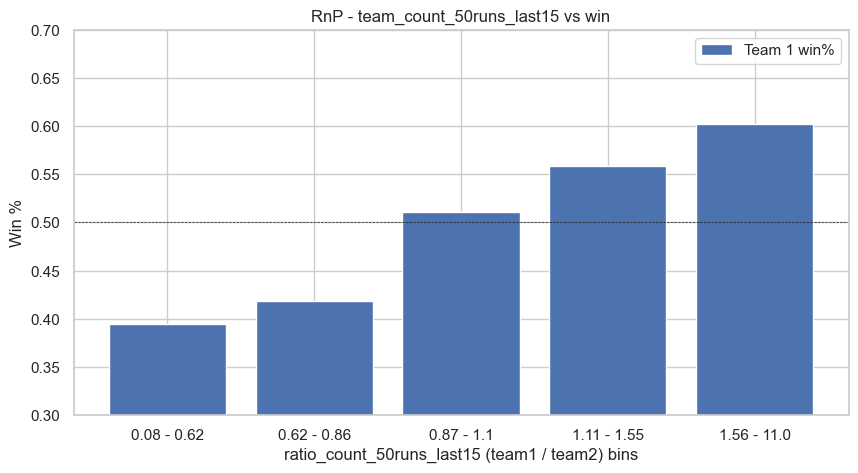

slope: 0.58 / 0.4 =  1.47


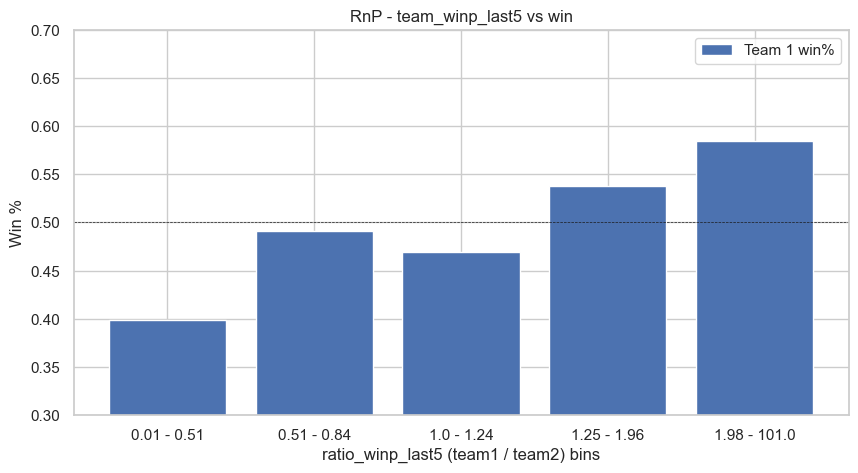

slope: 0.53 / 0.45 =  1.17


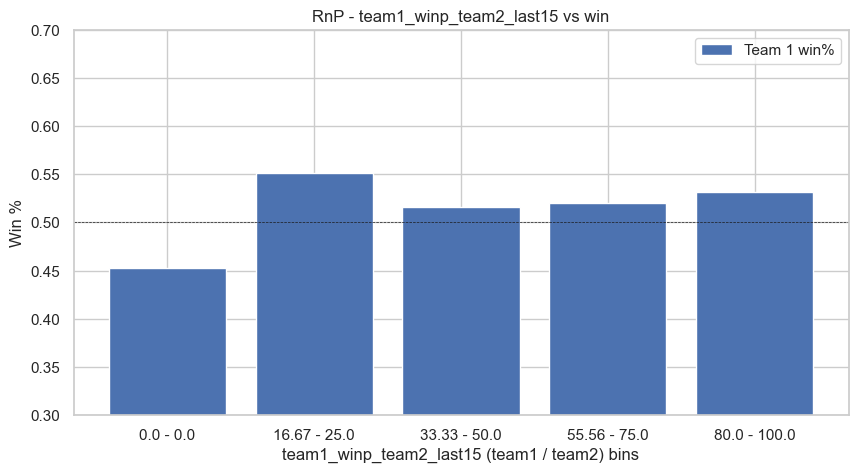

slope: 0.5 / 0.45 =  1.1


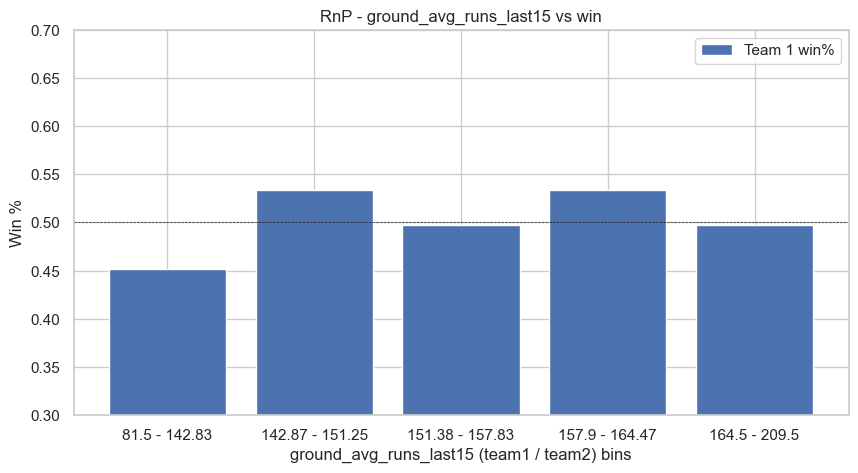

slope: 0.61 / 0.34 =  1.8


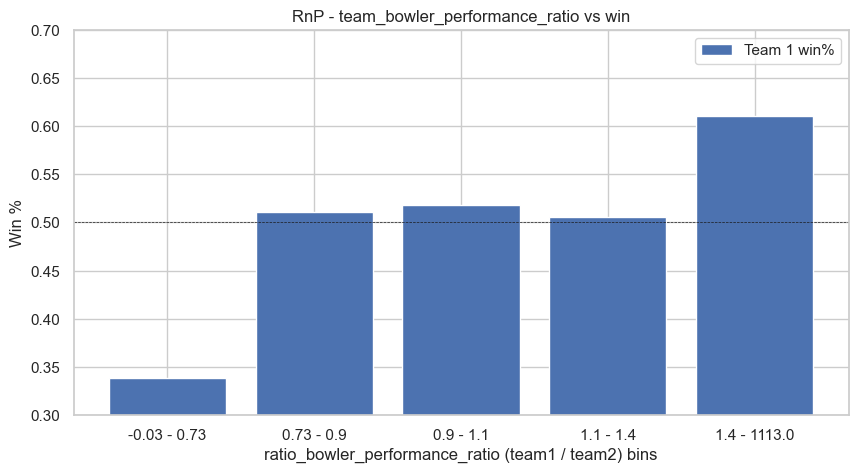

slope: 0.58 / 0.35 =  1.65


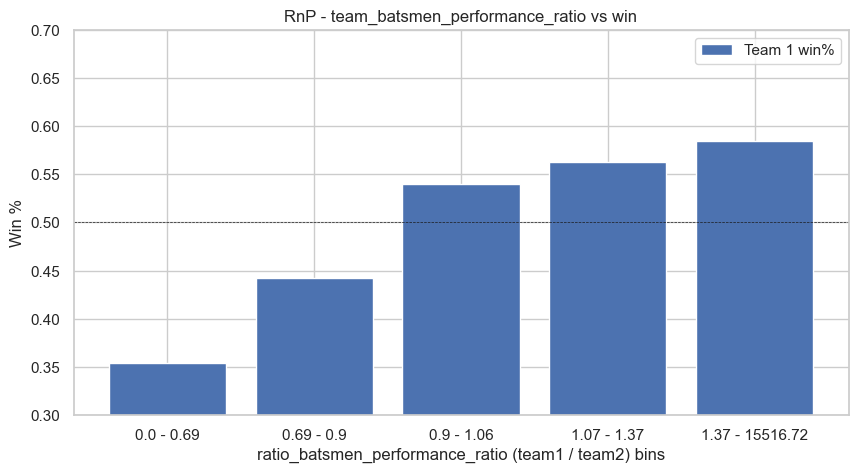

slope: 0.63 / 0.34 =  1.87


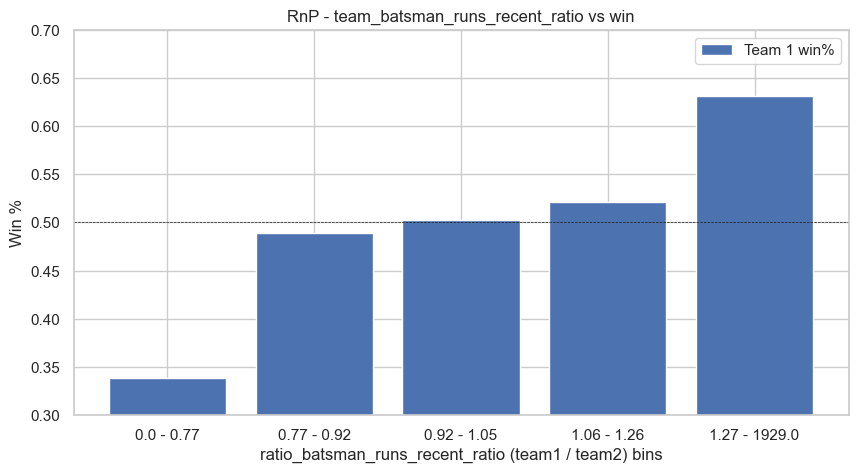

slope: 0.49 / 0.46 =  1.07


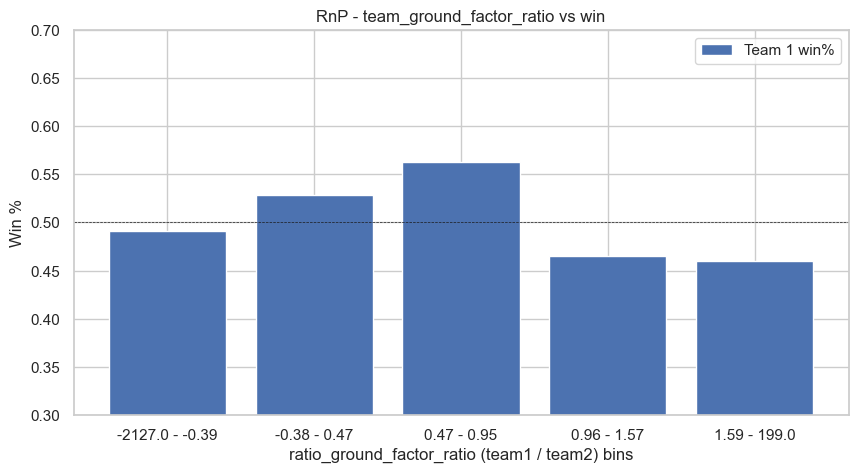

slope: 0.49 / 0.46 =  1.05


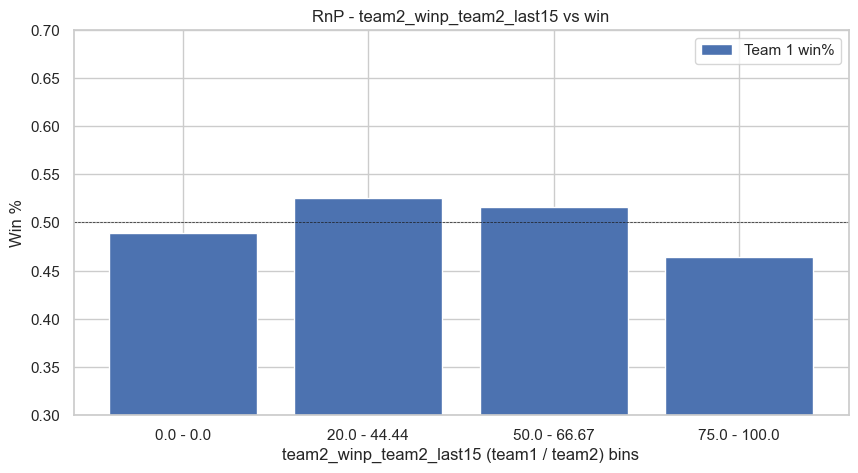

slope: 0.58 / 0.42 =  1.37


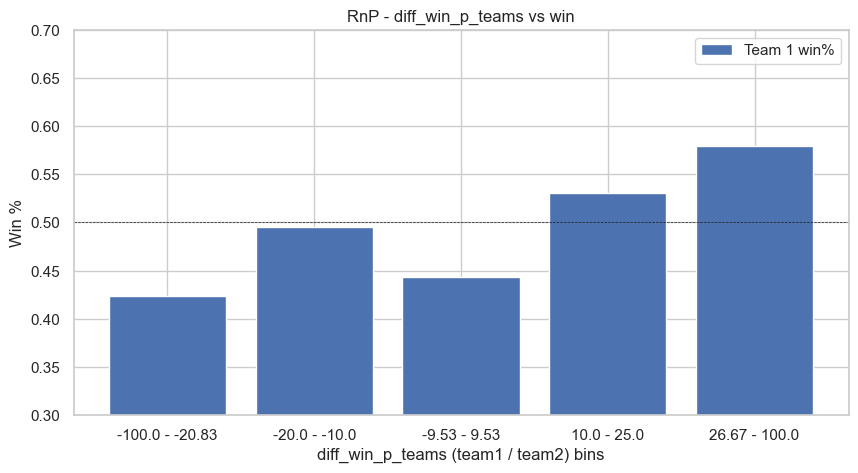

slope: 0.48 / 0.48 =  1.01


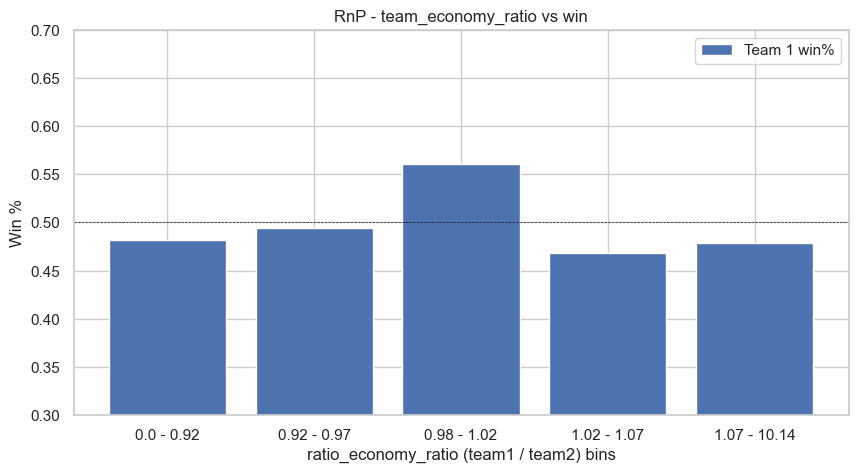

slope: 0.53 / 0.39 =  1.36


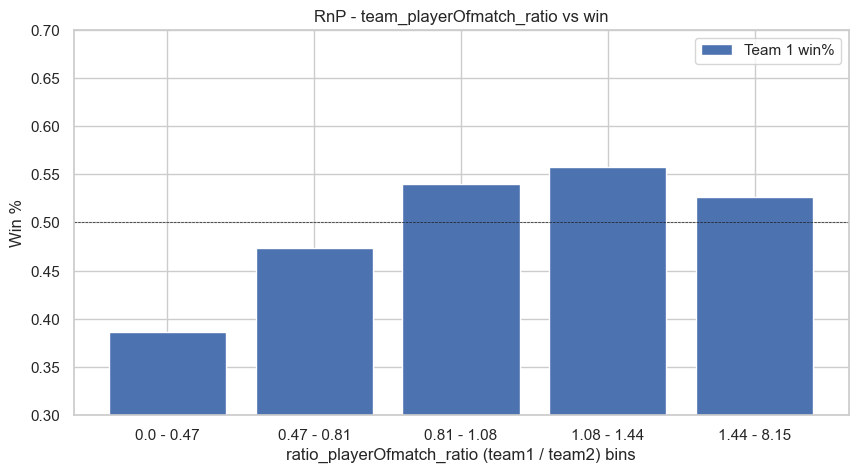

slope: 0.59 / 0.4 =  1.48


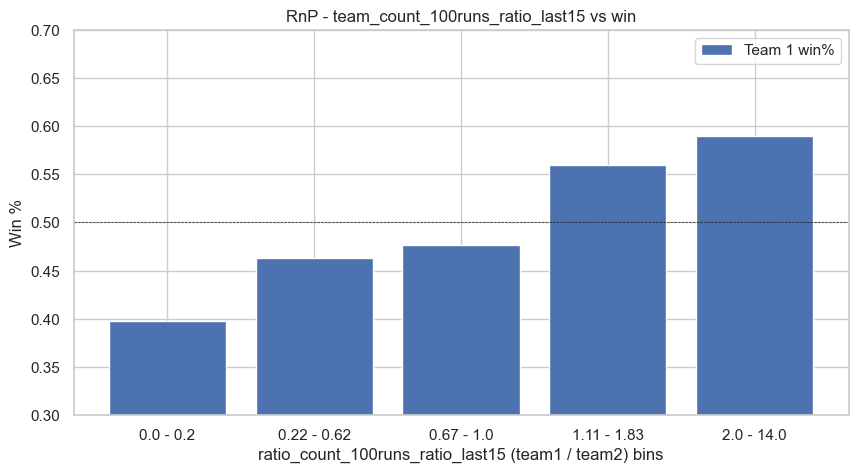

slope: 0.51 / 0.45 =  1.15


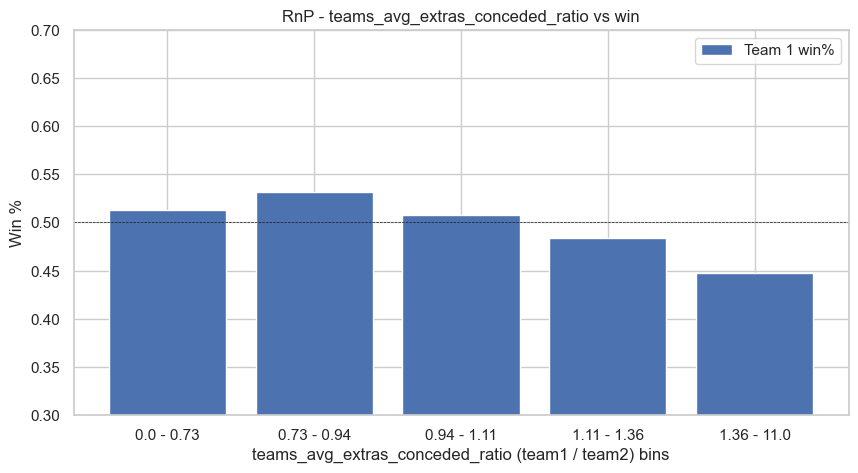

slope: 0.58 / 0.45 =  1.29


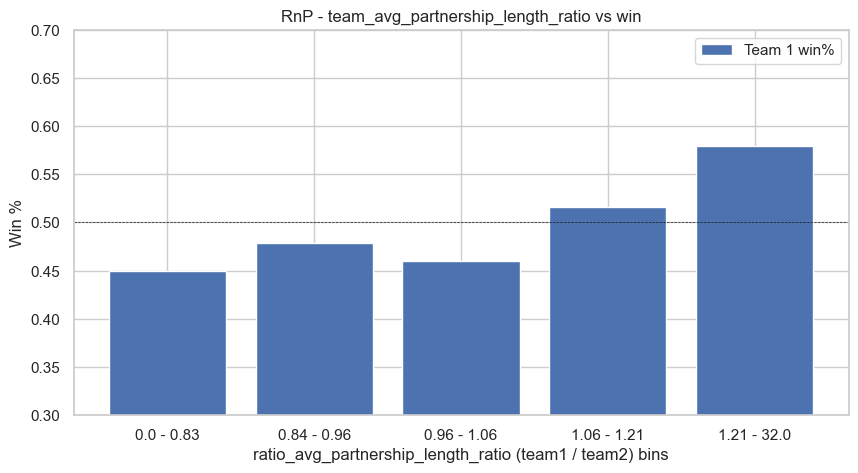

In [81]:
features = [
    'team_count_50runs_last15', 'team_winp_last5', 'team1_winp_team2_last15',
    'ground_avg_runs_last15', 'team_bowler_performance_ratio',
    'team_batsmen_performance_ratio', 'team_batsman_runs_recent_ratio',
    'team_ground_factor_ratio', 'team2_winp_team2_last15', 'diff_win_p_teams',
    'team_economy_ratio', 'team_playerOfmatch_ratio',
    'team_count_100runs_ratio_last15', 'teams_avg_extras_conceded_ratio',
    'team_avg_partnership_length_ratio', 
]

for feature in features:
    createRnP(train_data, feature)


In [82]:
for feature in features:
    createRnP(train_data,features)


ValueError: Cannot set a DataFrame with multiple columns to the single column ['team_count_50runs_last15', 'team_winp_last5', 'team1_winp_team2_last15', 'ground_avg_runs_last15', 'team_bowler_performance_ratio', 'team_batsmen_performance_ratio', 'team_batsman_runs_recent_ratio', 'team_ground_factor_ratio', 'team2_winp_team2_last15', 'diff_win_p_teams', 'team_economy_ratio', 'team_playerOfmatch_ratio', 'team_count_100runs_ratio_last15', 'teams_avg_extras_conceded_ratio', 'team_avg_partnership_length_ratio']_bin

In [ ]:
from matplotlib import pyplot as plt
plt.style.use('seaborn');
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

# Set seaborn style
sns.set(style="whitegrid")

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();


In [ ]:
train_data.columns

In [ ]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_batsman_runs_recent_ratio')

# team_avg_partnership_length_ratio,team_playerOfmatch_ratio,team_economy_ratio, diff_win_p_teams,diff_win_p_teams,team_ground_factor_ratio
